In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
import datetime
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from random import shuffle

In [2]:
def query_ic_graph(query, bind):
    if not isinstance(bind, list):
        bind = [bind]
    sparql = SPARQLWrapper(
#         "http://130.37.53.36:6789/sparql"
        "https://data.interconnect.labs.vu.nl/sparql"
    )
    sparql.setReturnFormat(JSON)

    sparql.setQuery(query)

    all_res = {}
    try:
        ret = sparql.queryAndConvert()
    #     print("ret:", ret)
        for b in bind:
            res = []
            for r in ret["results"]["bindings"]:
    #             print(r[bind]["value"])
                res.append(r[b]["value"])
            all_res[b] = res
    except Exception as e:
        print(e)
    if len(all_res.keys()) == 1:
        return all_res[bind[0]]
    return all_res

In [3]:
q_get_all_rooms_for_property = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX saref: <https://saref.etsi.org/core/>
    PREFIX ic: <https://interconnectproject.eu/example/>
    PREFIX s4bldg: <https://saref.etsi.org/saref4bldg/>

SELECT DISTINCT ?room1 WHERE {{
  ?dev1 saref:measuresProperty ?pred1 .
  ?pred1 a {} .
  ?dev1 s4bldg:isContainedIn ?room1 .
}}
"""
###  ?room1 rdfs:label "room" .

In [4]:
def make_dict_dev_val_time(query_results, dev_key="dev1", val_key="val1", time_key="time1"):
    dev_dict = {}
    for dev, val, time in zip(query_results[dev_key], query_results[val_key], query_results[time_key]):
#         print(dev, val, time)
        val = float(val)
        try:
            dev_dict[dev]["val"].append(val)
            dev_dict[dev]["time"].append(time)
        except:
            dev_dict[dev] = {}
            dev_dict[dev]["val"] = [val]
            dev_dict[dev]["time"] = [time]
    return dev_dict

In [5]:
def datetime_from_str(list_of_strings):
    times = []
    for t in list_of_strings:
        times.append(datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%S'))
    return times

def float_from_str(list_of_strings):
    floats = []
    for t in list_of_strings:
        floats.append(float(t))
    return floats

In [6]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:olive', 'tab:cyan']
# colors += ['b', 'g', 'r']
# colors = list(mcolors.CSS4_COLORS)
max_temp = 36
min_temp = 10
                        
delta_days = 1                        #IMPORTANT!!
time_delta = datetime.timedelta(days=delta_days)


def make_dev_color_dict(devs):
    shuffle(colors)
    dev_c_dict = {}
    if len(colors) < len(devs):
        print("TOO FEW COLORS!!!")
        exit()
    for dev, c in zip(devs, colors):
        dev_c_dict[dev] = c
    return dev_c_dict

def unique_devices_in_room_dev_dict(rooms_dev_dict):
    all_devices = []
    for room_key in rooms_dev_dict.keys():
#        print(room_key)
        for time_key in rooms_dev_dict[room_key].keys():
            for dev_key in rooms_dev_dict[room_key][time_key].keys():
#                print(dev_key)
                all_devices.append(dev_key)
    all_devices = list(set(all_devices))
    print("this dict contains", len(all_devices), "unique devices.")
    return all_devices

In [7]:
def add_meas_state(dev_dict, color_dict=[]):
    for dev_key in dev_dict.keys():
        vals = dev_dict[dev_key]["val"]
        times = dev_dict[dev_key]["time"]
        times = datetime_from_str(times)
        if not color_dict == []: use_color = color_dict[dev_key]
        else: use_color = "tab:blue"
        for t, v in zip(times, vals):
            if v == 1:
                plt.plot([t,t], [((max_temp+min_temp)*(7/16)), max_temp], marker='v', c=color_dict[dev_key], zorder=10)
            else:
                plt.plot([t,t], [min_temp, ((max_temp+min_temp)*(9/16))], marker='^', c=color_dict[dev_key], zorder=10)
                
def add_meas_scatter(dev_dict, color_dict=[]):
    for dev_key in dev_dict.keys():
        if not color_dict == []: use_color = color_dict[dev_key]
        else: use_color = "tab:green"
        vals = dev_dict[dev_key]["val"]
        times = dev_dict[dev_key]["time"]
        times = datetime_from_str(times)
        plt.scatter(times, vals, c=use_color, s=50, zorder=100)
        
def add_meas_line(dev_dict, lines=None, color_dict=[], lines_str="", style=None):
    for dev_key in dev_dict.keys():
        if lines != None:
            lines.append(dev_key.replace("https://interconnectproject.eu/example/", "ic:")+lines_str)
        if not color_dict == []: use_color = color_dict[dev_key]
        else: use_color = "gainsboro"
        vals = dev_dict[dev_key]["val"]
        times = dev_dict[dev_key]["time"]
        vals = [x for _, x in sorted(zip(times, vals))]
        times = sorted(times)
        times = datetime_from_str(times)
        if style == None:
            plt.plot(times, vals, c=use_color, zorder=1)
        else:
            plt.plot(times, vals, c=use_color, zorder=1, linestyle=style)
    return lines
        

In [8]:
q_get_meas_of_prop_on_room = """
 PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
 PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
 PREFIX s4ener: <https://saref.etsi.org/saref4ener/>
 PREFIX s4bldg: <https://saref.etsi.org/saref4bldg/>
 PREFIX saref: <https://saref.etsi.org/core/>
 PREFIX ic: <https://interconnectproject.eu/example/>

 SELECT DISTINCT ?dev ?time ?val WHERE {{
  ?dev s4bldg:isContainedIn {} .
  ?dev saref:measuresProperty ?pred .
  ?pred a {} .
  ?dev saref:makesMeasurement ?meas .
  ?meas saref:relatesToProperty ?pred .
  ?meas saref:hasTimestamp ?time .
  ?meas saref:hasValue ?val .
}}
"""

q_get_meas_of_prop_on_room_around_time = """
 PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
 PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
 PREFIX s4ener: <https://saref.etsi.org/saref4ener/>
 PREFIX s4bldg: <https://saref.etsi.org/saref4bldg/>
 PREFIX saref: <https://saref.etsi.org/core/>
 PREFIX ic: <https://interconnectproject.eu/example/>

 SELECT DISTINCT ?dev ?time ?val WHERE {{
  ?dev s4bldg:isContainedIn <{}> .
  ?dev saref:measuresProperty ?pred .
  ?pred a {} .
  ?dev saref:makesMeasurement ?meas .
  ?meas saref:relatesToProperty ?pred .
  ?meas saref:hasTimestamp ?time .
  ?meas saref:hasValue ?val .
  FILTER ( ?time >= '{}'^^xsd:dateTime && ?time <= '{}'^^xsd:dateTime )  
}}
"""

In [9]:
def query_for_meas_on_room_prop(room, property_type):
    print("Starting on room:", room)
    query_result = query_ic_graph(q_get_meas_of_prop_on_room.format(room, property_type), ["dev", "time", "val"])
#     print(query_result)
    meas_dict = make_dict_dev_val_time(query_result, dev_key="dev", val_key="val", time_key="time")
    return meas_dict


### STARTING POINT

In [10]:
room_name = "ic:roomname_3.009"
print("Working on room", room_name)

Working on room ic:roomname_3.009


In [11]:
humidity_dict = query_for_meas_on_room_prop(room_name, "saref:Humidity")

Starting on room: ic:roomname_3.009


In [12]:
CO2_dict = query_for_meas_on_room_prop(room_name, "ic:CO2Level")

Starting on room: ic:roomname_3.009


In [13]:
temp_dict = query_for_meas_on_room_prop(room_name, "saref:Temperature")

Starting on room: ic:roomname_3.009


In [14]:
import numpy as np

In [15]:
def scale_to_100(dev_dict):
    dict_copy = dev_dict.copy()
    for dev_key in dev_dict.keys():
        val = dev_dict[dev_key]["val"]
        print("max value:", max(val), "of", dev_key)
        val_adj = (np.array(val)/max(val))*100
        dict_copy[dev_key]["val"] = list(val_adj)
    return(dict_copy)

In [16]:
CO2_dict2 = scale_to_100(CO2_dict)

max value: 1205.0 of https://interconnectproject.eu/example/R5_76


In [17]:
temp_dict2= scale_to_100(temp_dict)

max value: 25.8 of https://interconnectproject.eu/example/R5_76
max value: 30.3 of https://interconnectproject.eu/example/Zigbee_Thermostat_1


In [18]:
CO2_color_dict = make_dev_color_dict(list(CO2_dict.keys()))
temp_color_dict= make_dev_color_dict(list(temp_dict2.keys()))

In [19]:
def create_office_climate_plot(year, month, day, style=None, dontplot=False):
    lines = []
    lines = add_meas_line(humidity_dict, lines, lines_str="_Humidity (%)",style=style)
    lines = add_meas_line(CO2_dict2, lines, CO2_color_dict, lines_str="_CO2 (scaled ppm)",style=style)
    lines = add_meas_line(temp_dict2, lines, temp_color_dict, lines_str="_Temperature (scaled ˚C)",style=style)
    # start_time = datetime_from_str("2022-11-17T17:36:00")
    start_time = datetime.datetime(year, month, day, hour=0, minute=0, second=0)
    end_time = start_time + datetime.timedelta(days=1)
    plt.xlim(start_time, end_time)
    plt.ylim(0, 100)
    # plt.ylabel("")
    plt.xlabel("Time of day")
    plt.xticks( rotation=25 )
    plt.legend(lines, bbox_to_anchor=(0.5, 1.3), loc='upper center')
    # plt.legend(lines)
    if not dontplot:
        plt.show()
#         plt.savefig('humiVSco2_days.eps', format='eps', bbox_inches="tight")

In [20]:
def create_office_climate_plots(year, month, day, axis):
    lines = []
    lines = add_meas_line_axis(humidity_dict, axis, lines, lines_str="_Humidity (%)")
    lines = add_meas_line_axis(CO2_dict2, axis, lines, CO2_color_dict, lines_str="_CO2 (scaled ppm)")
    lines = add_meas_line_axis(temp_dict2, axis, lines, temp_color_dict, lines_str="_Temperature (scaled ˚C)")
    # start_time = datetime_from_str("2022-11-17T17:36:00")
    start_time = datetime.datetime(year, month, day, hour=0, minute=0, second=0)
    end_time = start_time + datetime.timedelta(days=1)
    axis.set(ylim=(0,100), xlim=(start_time, end_time), xlabel="Time")
    return axis
    # plt.ylabel("")
#     plt.xticks( rotation=25 )
#     plt.legend(lines, bbox_to_anchor=(0.5, 1.3), loc='upper center')
    # plt.legend(lines)
    # plt.savefig('humiVSco2.eps', format='eps', bbox_inches="tight")
    
        
def add_meas_line_axis(dev_dict, axis, lines=None, color_dict=[], lines_str=""):
    for dev_key in dev_dict.keys():
        if lines != None:
            lines.append(dev_key.replace("https://interconnectproject.eu/example/", "ic:")+lines_str)
        if not color_dict == []: use_color = color_dict[dev_key]
        else: use_color = "gainsboro"
        vals = dev_dict[dev_key]["val"]
        times = dev_dict[dev_key]["time"]
        vals = [x for _, x in sorted(zip(times, vals))]
        times = sorted(times)
        times = datetime_from_str(times)
        axis.plot(times, vals, c=use_color, zorder=1)
    return lines

In [21]:
def create_office_climate_plot_fake_days(year, month, day, d, style=None):
    lines = []
    lines = add_meas_line_fake_days(humidity_dict, d, lines, lines_str="_Humidity (%)",style=style)
    lines = add_meas_line_fake_days(CO2_dict2, d, lines, CO2_color_dict, lines_str="_CO2 (scaled ppm)",style=style)
    lines = add_meas_line_fake_days(temp_dict2, d, lines, temp_color_dict, lines_str="_Temperature (scaled ˚C)",style=style)
    # start_time = datetime_from_str("2022-11-17T17:36:00")
    start_time = datetime.datetime(year, month, day, hour=0, minute=0, second=0)
    end_time = start_time + datetime.timedelta(days=1)
    plt.xlim(start_time, end_time)
    plt.ylim(0, 100)
    # plt.ylabel("")
    plt.xlabel("Time")
    plt.xticks( rotation=25 )
    plt.legend(lines, bbox_to_anchor=(0.5, 1.3), loc='upper center')
    # plt.legend(lines)
    # plt.savefig('humiVSco2.eps', format='eps', bbox_inches="tight")

def add_meas_line_fake_days(dev_dict, d, lines=None, color_dict=[], lines_str="", style=None):
    for dev_key in dev_dict.keys():
        if lines != None:
            lines.append(dev_key.replace("https://interconnectproject.eu/example/", "ic:")+lines_str)
        if not color_dict == []: use_color = color_dict[dev_key]
        else: use_color = "gainsboro"
        vals = dev_dict[dev_key]["val"]
        times = dev_dict[dev_key]["time"]
        vals = [x for _, x in sorted(zip(times, vals))]
        times = sorted(times)
        times = datetime_from_str(times)
        new_times = []
        for t in times:
            new_times.append(t+datetime.timedelta(days=d))
        if style == None:
            plt.plot(new_times, vals, c=use_color, zorder=1)
        else:
            plt.plot(new_times, vals, c=use_color, zorder=1, linestyle=style)
    return lines
        

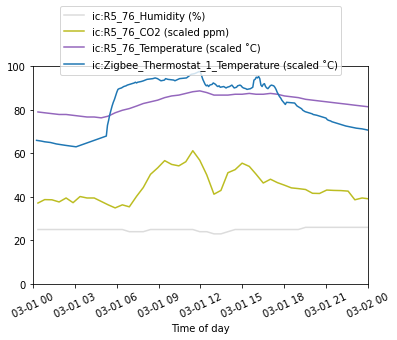

In [22]:
create_office_climate_plot(2022, 3, 1)

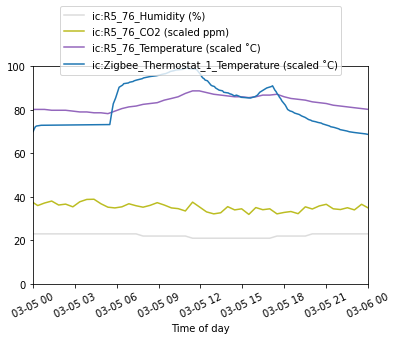

In [23]:
create_office_climate_plot(2022, 3, 5)

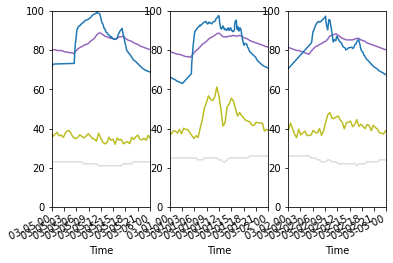

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1 = create_office_climate_plots(2022, 3, 5, ax1)
ax2 = create_office_climate_plots(2022, 3, 1, ax2)
ax3 = create_office_climate_plots(2022, 3, 2, ax3)
fig.autofmt_xdate(rotation=25)

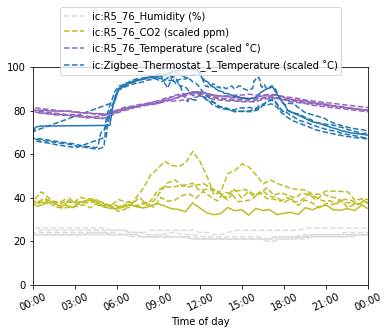

In [25]:
# dash_day = 
last_day = 5 #saturday

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# create_office_climate_plot_fake_days(2022, 3, last_day-6, 6)
# create_office_climate_plot_fake_days(2022, 3, last_day-5, 5)
create_office_climate_plot_fake_days(2022, 3, last_day-4, 4, style="dashed")
create_office_climate_plot_fake_days(2022, 3, last_day-3, 3, style="dashed")
create_office_climate_plot_fake_days(2022, 3, last_day-2, 2, style="dashed")
create_office_climate_plot_fake_days(2022, 3, last_day-1, 1, style="dashed")
# create_office_climate_plot_fake_days(2022, 3, last_day-1, 1, style="dashed")
create_office_climate_plot(2022, 3, last_day)